In [1]:
!git clone https://github.com/misbah4064/opencvTutorial.git
from IPython.display import clear_output
clear_output()

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import os
import cv2
from matplotlib import pyplot as plt

# Function to denoise an image
def denoise_image(image):
    dst = cv2.fastNlMeansDenoisingColored(image, None, 11, 6, 7, 21)
    return dst

# Input and output folder paths
input_folder = '/content/drive/MyDrive/dataset-new-1/'
output_folder = '/content/drive/MyDrive/output/'

# Create the output folder if it doesn't exist
#os.makedirs(output_folder, exist_ok=True)

# Process each image in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        input_path = os.path.join(input_folder, filename)

        # Read the image
        image = cv2.imread(input_path)

        # Apply denoising
        denoised_image = denoise_image(image)

        # Save the denoised image to the output folder
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, denoised_image)

print('Denoising complete!')

Denoising complete!


In [4]:
import tensorflow as tf
print(tf.version.VERSION)

2.12.0


In [5]:
import keras
keras.__version__

'2.12.0'

In [6]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
path = "/content/drive" + "/My Drive/" + "https://drive.google.com/drive/folders/1wEOFT3ZFftLS9lEDyR3JcYSq65nEgFCU?usp=sharing/"

print(path)

Mounted at /content/drive
/content/drive/My Drive/https://drive.google.com/drive/folders/1wEOFT3ZFftLS9lEDyR3JcYSq65nEgFCU?usp=sharing/


In [7]:
from tensorflow.python.keras.models import Input

In [8]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten
from tensorflow.python.keras.models import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
train_images = sorted(os.listdir('/content/drive/MyDrive/output/'))
train_image = []

for im in train_images:
    img = image.load_img('/content/drive/MyDrive/output/' + im, target_size=(64,64), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
train_df = np.array(train_image)

In [10]:
def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(40, 20)
    for i in range(1,7):
        ax[i-5].imshow(dataset[i].reshape(64,64),cmap='gray')
    plt.show()

In [11]:
def add_noise(image):
    row,col,ch= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss*0.03
    return noisy

In [12]:
noise_imgs= []

for img in train_df:
    noisy_img = add_noise(img)
    noise_imgs.append(noisy_img)

noise_imgs= np.array(noise_imgs)

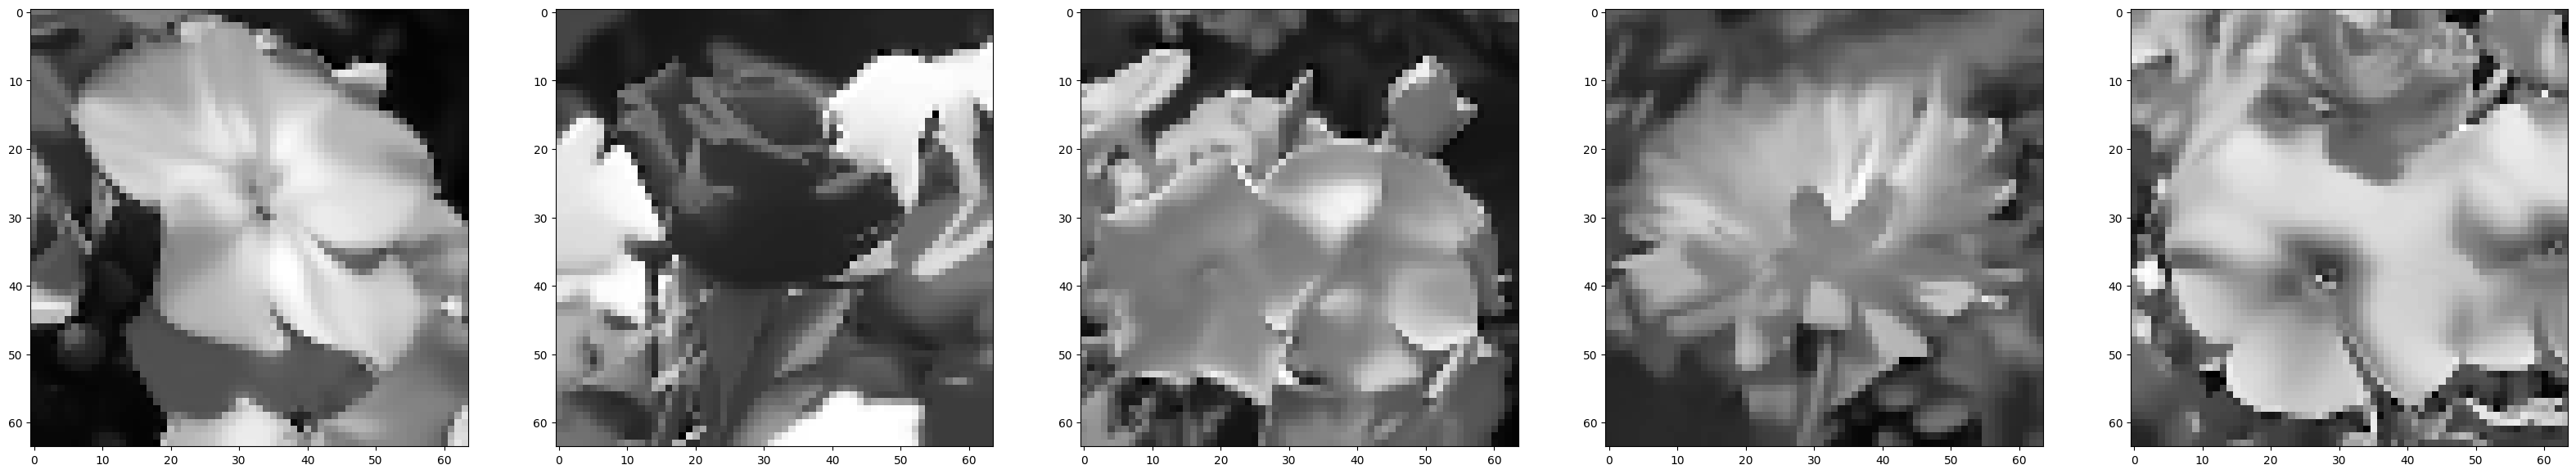

In [13]:
show_img(train_df)

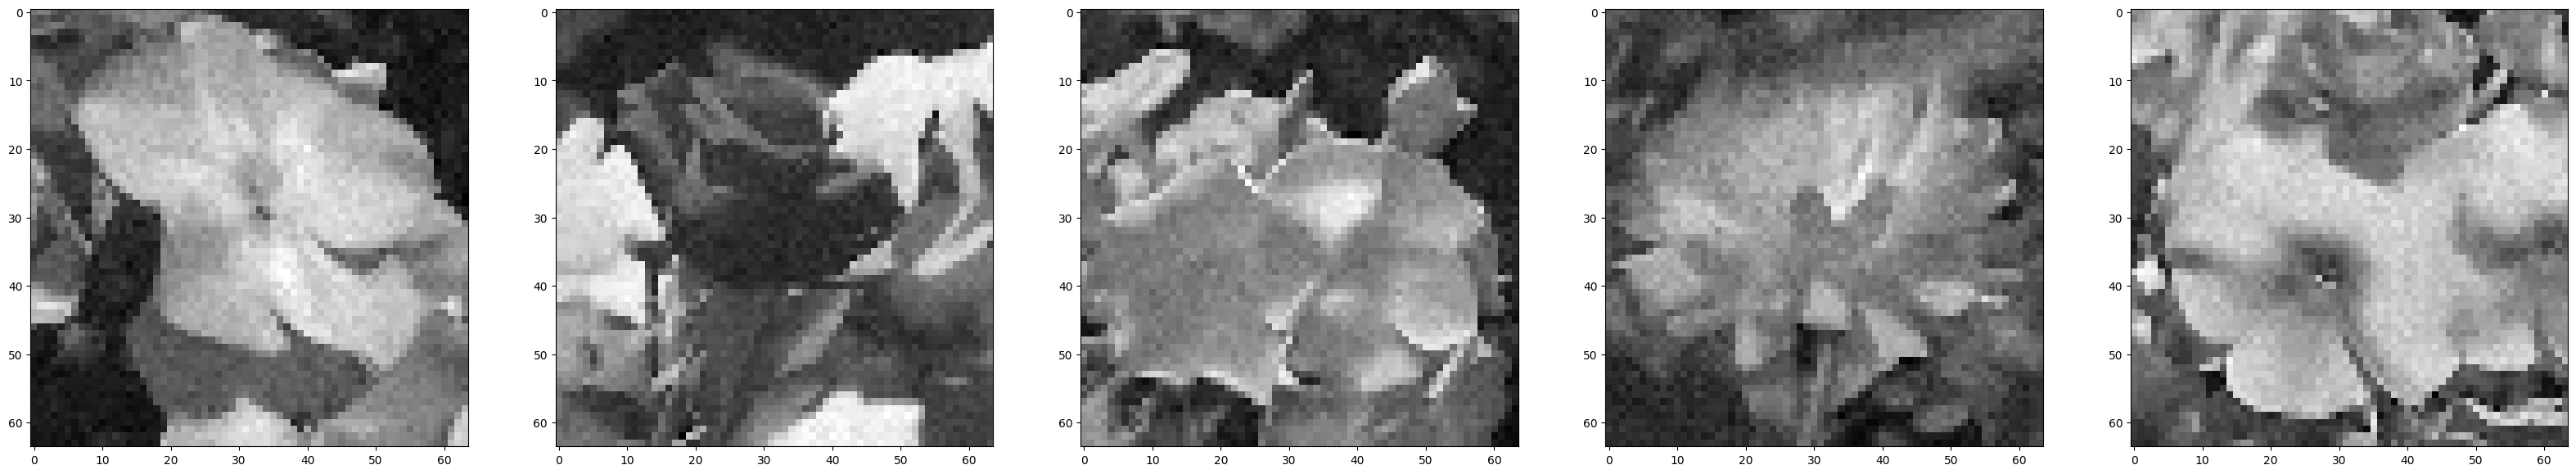

In [14]:
show_img(noise_imgs)

In [15]:
print('Noisy image shape: ',noise_imgs.shape,' Train image shape: ',train_df.shape)

Noisy image shape:  (1109, 64, 64, 1)  Train image shape:  (1109, 64, 64, 1)


In [16]:
xnoised= noise_imgs[0:80]
xtest= noise_imgs[80:]

In [17]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

def autoencoder():
    input_img = Input(shape=(64,64,1), name='image_input')

    # Encoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)

    # Decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)

    # Model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

model = autoencoder()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 64, 64, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 64, 64, 64)        640       
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 64)        0         
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 64)        36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 16, 16, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 upsample1 (UpSampling2D)    (None, 32, 32, 64)        0     

In [18]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(xnoised, xnoised,steps_per_epoch= 3, epochs=50, batch_size=2, validation_data=(xtest, xtest), callbacks=[early_stopping])

Epoch 1/50
3/3 [==============================] - 14s 708ms/step - loss: 0.6931 - val_loss: 0.6888
Epoch 2/50
3/3 [==============================] - 1s 648ms/step - loss: 0.6820 - val_loss: 0.7011
Epoch 3/50
3/3 [==============================] - 1s 645ms/step - loss: 0.6708 - val_loss: 0.6753
Epoch 4/50
3/3 [==============================] - 1s 645ms/step - loss: 0.6754 - val_loss: 0.6475
Epoch 5/50
3/3 [==============================] - 1s 547ms/step - loss: 0.6428 - val_loss: 0.6176
Epoch 6/50
3/3 [==============================] - 1s 538ms/step - loss: 0.5499 - val_loss: 0.5836
Epoch 7/50
3/3 [==============================] - 3s 1s/step - loss: 0.6281 - val_loss: 0.6238
Epoch 8/50
3/3 [==============================] - 1s 624ms/step - loss: 0.6509 - val_loss: 0.5844
Epoch 9/50
3/3 [==============================] - 1s 648ms/step - loss: 0.5798 - val_loss: 0.5591
Epoch 10/50
3/3 [==============================] - 1s 645ms/step - loss: 0.5557 - val_loss: 0.5474
Epoch 11/50
3/3 [====

In [19]:
xtrain= train_df[80:]

1/1 [==============================] - 0s 240ms/step


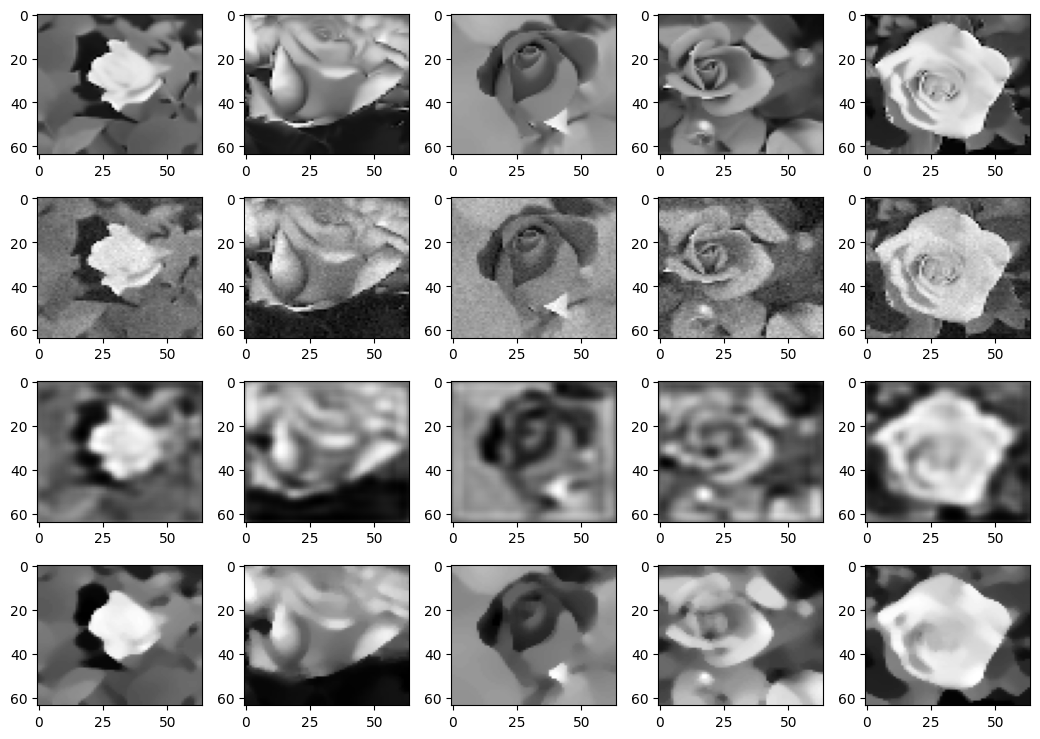

In [20]:
import cv2

pred= model.predict(xtest[:5])
def plot_predictions(y_true, y_pred):
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(xtrain[i], (64,64)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_true[i], (64,64)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(y_pred[i], (64,64)), aspect='auto', cmap='gray')
        ax[3][i].imshow(cv2.medianBlur(xtrain[i], (5)), aspect='auto', cmap='gray')

    plt.tight_layout()
plot_predictions(xtest[:5], pred[:5])

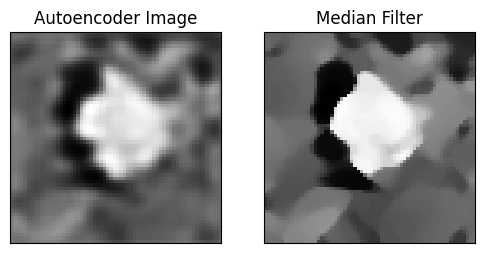

In [21]:
new_image = cv2.medianBlur(xtrain[0], (5))
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(pred[0].reshape(64,64), cmap='gray')
plt.title('Autoencoder Image')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(new_image, cmap='gray')
plt.title('Median Filter')
plt.xticks([])
plt.yticks([])
plt.show()

In [22]:
from math import log10, sqrt

def PSNR(original, denoiced):
    mse = np.mean((original - denoiced) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

value1 = PSNR(xtest[0], new_image)
value2 = PSNR(xtest[0], pred[0])

print(f"PSNR value for Denoised image is {value2} dB while for Median filtered image is {value1} dB")

PSNR value for Denoised image is 71.68168932767031 dB while for Median filtered image is 59.986764205057725 dB


In [23]:
# Step 2: Import libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [24]:
# Path to the dataset folders
color_images_folder = '/content/drive/MyDrive/input-dataset/color'
bw_images_folder = '/content/drive/MyDrive/input-dataset/black_and_white'

In [25]:
# Step 3: Load and preprocess the dataset
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
    return images

color_images = load_images_from_folder(color_images_folder)
bw_images = load_images_from_folder(bw_images_folder)

In [26]:
def preprocess_images(images):
    processed_images = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        img = cv2.resize(img, (100, 100))  # Resize the image to 100x100
        img = img.astype('float32') / 255.0  # Normalize pixel values between 0 and 1
        processed_images.append(img)
    return np.array(processed_images)

color_images = preprocess_images(color_images)
bw_images = preprocess_images(bw_images)

In [27]:
color_labels = np.zeros(len(color_images))
bw_labels = np.ones(len(bw_images))

In [28]:
data = np.concatenate((color_images, bw_images), axis=0)
labels = np.concatenate((color_labels, bw_labels), axis=0)


In [29]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

In [30]:
  # Step 4: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_one_hot, test_size=0.25, random_state=42)


In [31]:
# Step 5: Build the CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))  # 2 output classes: color and black-and-white

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [32]:
# Step 6: Train the CNN model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
24/24 [==============================] - 2s 50ms/step - loss: 0.6063 - accuracy: 0.7019 - val_loss: 0.4113 - val_accuracy: 0.8560
Epoch 2/50
24/24 [==============================] - 0s 17ms/step - loss: 0.3370 - accuracy: 0.8516 - val_loss: 0.2334 - val_accuracy: 0.8920
Epoch 3/50
24/24 [==============================] - 0s 17ms/step - loss: 0.1659 - accuracy: 0.9305 - val_loss: 0.0603 - val_accuracy: 0.9800
Epoch 4/50
24/24 [==============================] - 0s 19ms/step - loss: 0.0710 - accuracy: 0.9773 - val_loss: 0.0287 - val_accuracy: 0.9960
Epoch 5/50
24/24 [==============================] - 0s 18ms/step - loss: 0.0583 - accuracy: 0.9813 - val_loss: 0.1407 - val_accuracy: 0.9320
Epoch 6/50
24/24 [==============================] - 0s 18ms/step - loss: 0.0660 - accuracy: 0.9746 - val_loss: 0.0965 - val_accuracy: 0.9800
Epoch 7/50
24/24 [==============================] - 0s 18ms/step - loss: 0.0271 - accuracy: 0.9933 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 8/50
24

In [33]:
# Step 7: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy*100)

8/8 [==============================] - 0s 7ms/step - loss: 0.0353 - accuracy: 0.9960
Test loss: 0.03528134152293205
Test accuracy: 99.59999918937683


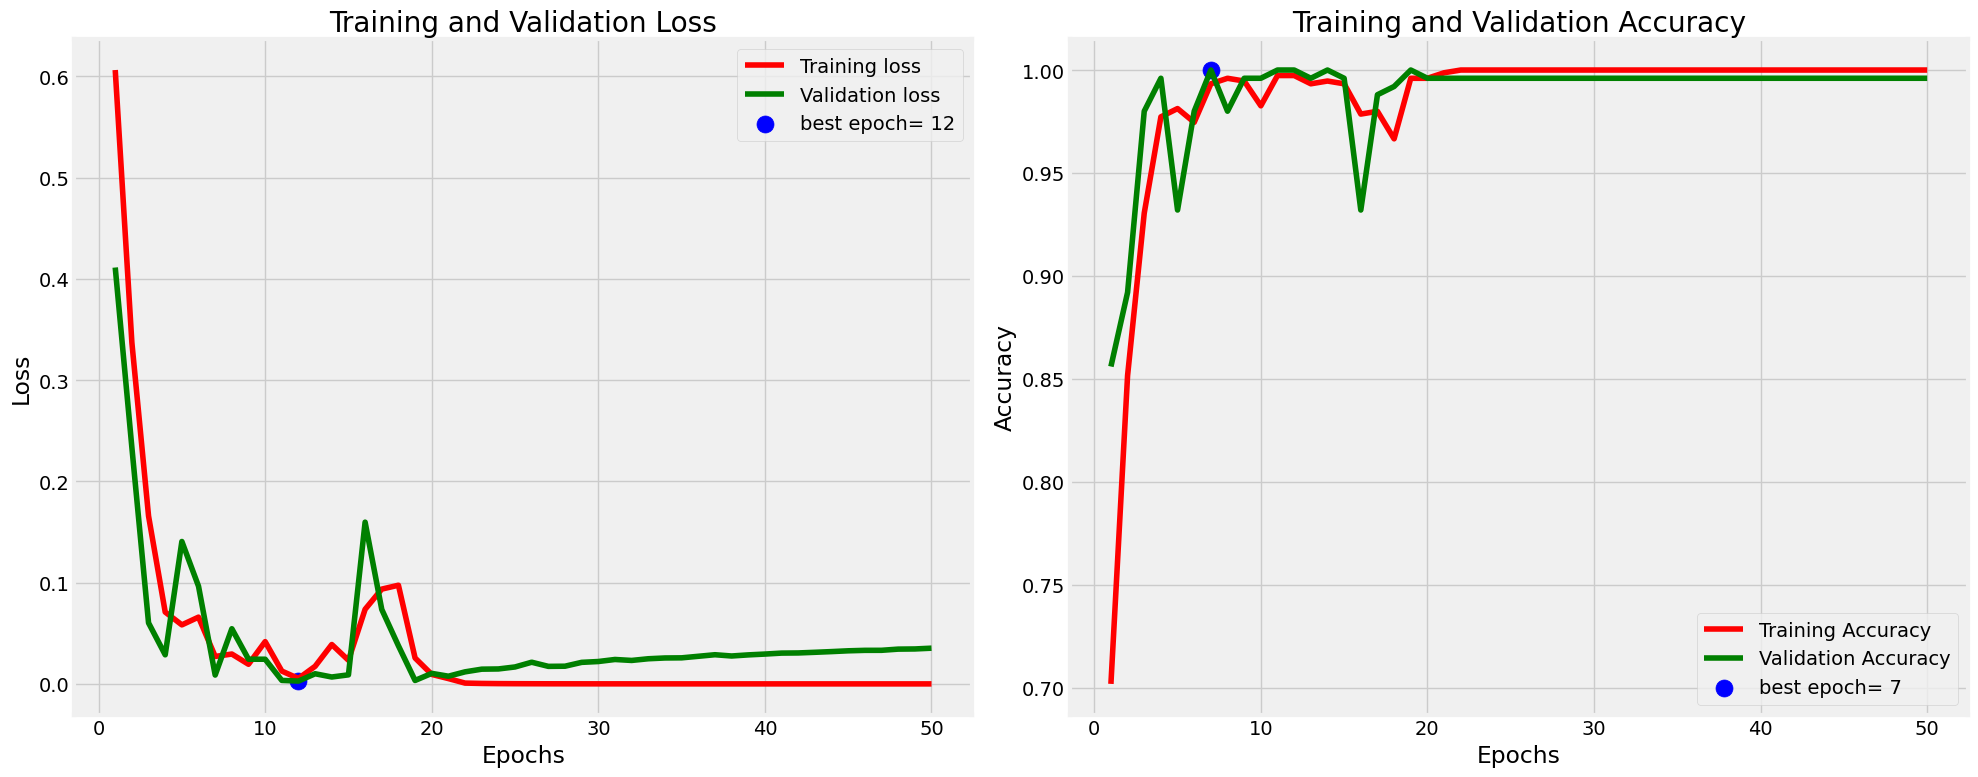

In [34]:
# # Step 8: Plot training and validation accuracy
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training(history)


In [35]:
# Step 9: Classify new images
def predict_image_class(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    class_index = np.argmax(prediction)
    class_label = "color" if class_index == 0 else "black-and-white"

    return class_label

# Example usage:
#new_image_path = '/content/gdrive/MyDrive/input-dataset/color/color  (455).png'  # Replace with the path of the new image to classify
new_image_path = '/content/drive/MyDrive/input-dataset/black_and_white/bw (1).jpg'  # Replace with the path of the new image to classify

predicted_class = predict_image_class(model, new_image_path)

print("The image is classified as:", predicted_class)

1/1 [==============================] - 0s 271ms/step
The image is classified as: black-and-white


In [36]:

# Step 9: Classify new images
def predict_image_class(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    class_index = np.argmax(prediction)
    class_label = "color" if class_index == 0 else "black-and-white"

    return class_label

# Example usage:
#new_image_path='/content/gdrive/MyDrive/IMG-20221130-WA0008.jpg'
new_image_path = '/content/drive/MyDrive/input-dataset/color/color  (1).png'  # Replace with the path of the new image to classify
#new_image_path = '/content/gdrive/MyDrive/input-dataset/black_and_white/bw (501).jpg'  # Replace with the path of the new image to classify

predicted_class = predict_image_class(model, new_image_path)

print("The image is classified as:", predicted_class)

1/1 [==============================] - 0s 27ms/step
The image is classified as: color


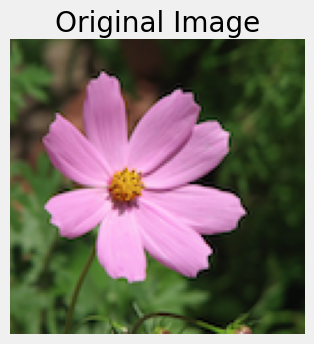

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Replace 'path_to_image' with the actual path to your image file
image_path=new_image_path
#image_path = '/content/gdrive/MyDrive/input-dataset/color/color  (455).png'
image = mpimg.imread(image_path)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.show()


1/1 [==============================] - 0s 19ms/step
Image: /content/drive/MyDrive/input-dataset/color/color  (1).png
Class: color

Image: /content/drive/MyDrive/input-dataset/black_and_white/bw (1).jpg
Class: black-and-white



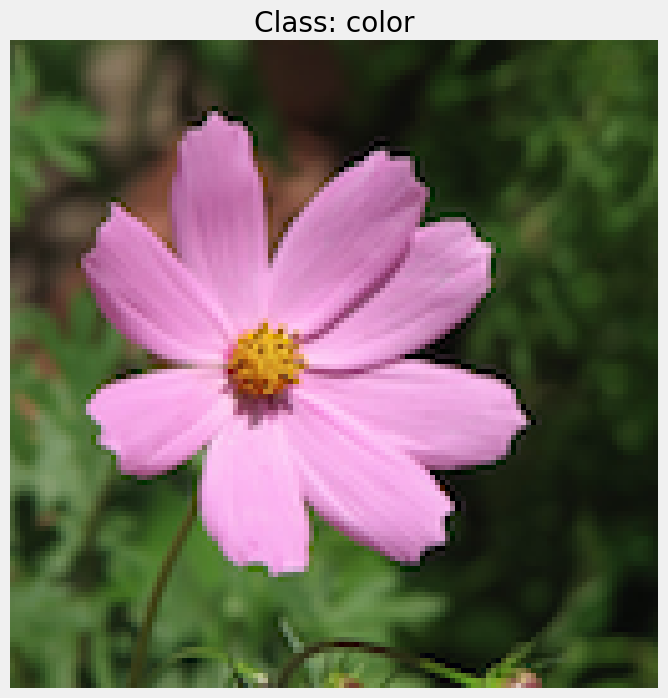

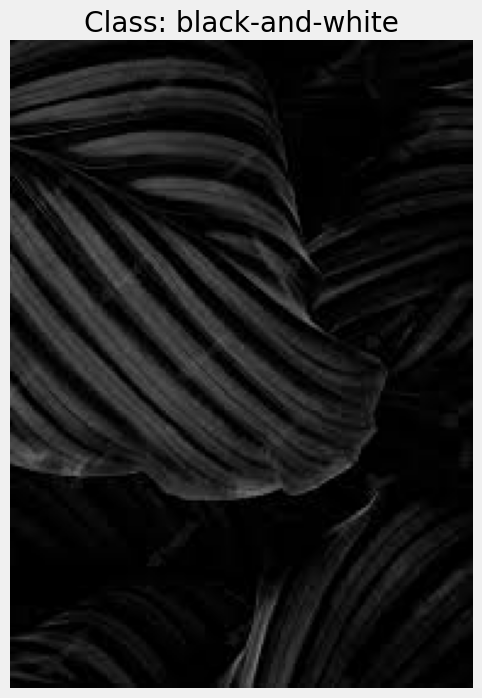

In [38]:
def predict_image_class(model, img_paths):
    predicted_classes = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 100))
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=0)

        prediction = model.predict(img)
        class_index = np.argmax(prediction)
        class_label = "color" if class_index == 0 else "black-and-white"
        predicted_classes.append(class_label)

    return predicted_classes

# Example usage:
new_image_paths = [
    '/content/drive/MyDrive/input-dataset/color/color  (1).png',
    #'/content/gdrive/MyDrive/input-dataset/black_and_white/bw (55).jpg',
    '/content/drive/MyDrive/input-dataset/black_and_white/bw (1).jpg'
]  # Replace with the paths of the new images to classify

predicted_classes = predict_image_class(model, new_image_paths)

for img_path, predicted_class in zip(new_image_paths, predicted_classes):
    print("Image:", img_path)
    print("Class:", predicted_class)
    print()

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for img_path, predicted_class in zip(new_image_paths, predicted_classes):
    image = mpimg.imread(img_path)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title('Class: ' + predicted_class)
    plt.axis('off')
    plt.show()

In [ ]:
# Step 10: Classify all images in the dataset
import os

# Function to predict the class of multiple images
def predict_image_classes(model, img_paths):
    predicted_classes = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 100))
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=0)

        prediction = model.predict(img)
        class_index = np.argmax(prediction)
        class_label = "color" if class_index == 0 else "black-and-white"
        predicted_classes.append(class_label)

    return predicted_classes

# Get all image paths from the dataset folders
all_color_image_paths = [os.path.join(color_images_folder, filename) for filename in os.listdir(color_images_folder)]
all_bw_image_paths = [os.path.join(bw_images_folder, filename) for filename in os.listdir(bw_images_folder)]

# Combine the two lists of image paths
all_image_paths = all_color_image_paths + all_bw_image_paths

# Predict the classes of all images in the dataset
predicted_classes = predict_image_classes(model, all_image_paths)

# Print the output for each image
for img_path, predicted_class in zip(all_image_paths, predicted_classes):
    print("Image:", img_path)
    print("Class:", predicted_class)
    print()

# Optionally, you can also display each image along with its predicted class
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for img_path, predicted_class in zip(all_image_paths, predicted_classes):
    image = mpimg.imread(img_path)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title('Class: ' + predicted_class)
    plt.axis('off')
    plt.show()